In [267]:
# preparing notebook for visualization purposes
# (only show outputs between t=180s and t=240s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(210, 240)

# Downloading and setting up data

In [ ]:
!pip install pyannote.audio

In [ ]:
!git clone https://github.com/pyannote/AMI-diarization-setup/ && cd AMI-diarization-setup/pyannote && sh download_ami.sh

In [ ]:
# tell pyannote.database where to find partition, reference, and wav files
import os
os.environ["PYANNOTE_DATABASE_CONFIG"] = 'AMI-diarization-setup/pyannote/database.yml'

# used to automatically find paths to wav files
from pyannote.database import FileFinder
preprocessors = {'audio': FileFinder()}

# initialize 'only_words' experimental protocol
from pyannote.database import get_protocol
ami = get_protocol('AMI.SpeakerDiarization.only_words', preprocessors=preprocessors)

# iterate over the training set and checking that all is OK
for file in ami.train():
    meeting = file['uri']
    reference = file['annotation']
    path = file['audio']

# iterate over the development set and checking that all is OK
for file in ami.development():
    pass

# iterate over the test set and checking that all is OK
for file in ami.test():
    pass

# initialize 'word_and_vocalsounds' experimental protocol
word_and_vocalsounds = get_protocol('AMI.SpeakerDiarization.word_and_vocalsounds')

# Training, fine-tuning, and transfer learning with pyannote.audio

## Training a voice activity detection model from scratch

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.

We initialize a VAD task that describes how the model will be trained:
* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2`. and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [273]:
# Example of annotation (target) for audio in dataset

example_annotation = 'AMI-diarization-setup/only_words/rttms/dev/ES2011a.rttm'
with open(example_annotation, 'r') as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i == 5:
            break

SPEAKER ES2011a 1 34.27 10.12 <NA> <NA> FEE041 <NA> <NA>
SPEAKER ES2011a 1 46.43 10.42 <NA> <NA> FEE041 <NA> <NA>
SPEAKER ES2011a 1 58.56 5.72 <NA> <NA> FEE041 <NA> <NA>
SPEAKER ES2011a 1 65.0 12.78 <NA> <NA> FEE044 <NA> <NA>
SPEAKER ES2011a 1 77.04 3.75 <NA> <NA> FEE041 <NA> <NA>
SPEAKER ES2011a 1 78.93 3.96 <NA> <NA> FEE044 <NA> <NA>


In [270]:
from pyannote.audio.tasks import VoiceActivityDetection
vad_task = VoiceActivityDetection(ami, duration=2.0, batch_size=128)

Protocol AMI.SpeakerDiarization.only_words does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad_task`) for which it is being trained:

In [7]:
from pyannote.audio.models.segmentation import PyanNet
vad_model = PyanNet(task=vad_task, sincnet={'stride': 10})

In [138]:
vad_model

PyanNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (lstm): LSTM(60, 128, num_layers=2, batch_first=True, bidirectional=True)
  (linear): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=1, bias=True)
  (acti

In [11]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=2)
trainer.fit(vad_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 589 K  | [1, 115, 60]  | [[1, 115, 256], [[4, 1, 128], [4, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?             | ?                                          
3 | classifier        | Linear           | 129    | [1, 115, 128] | [1, 115, 1]                                
4 | activation        | Sigmoid          | 0      | [1, 115, 1]   | [1, 115, 1]                                
5 | valid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [216]:
test_file = next(ami.test())

Let's see 30s segment of test audio with vad predicted probabilities 


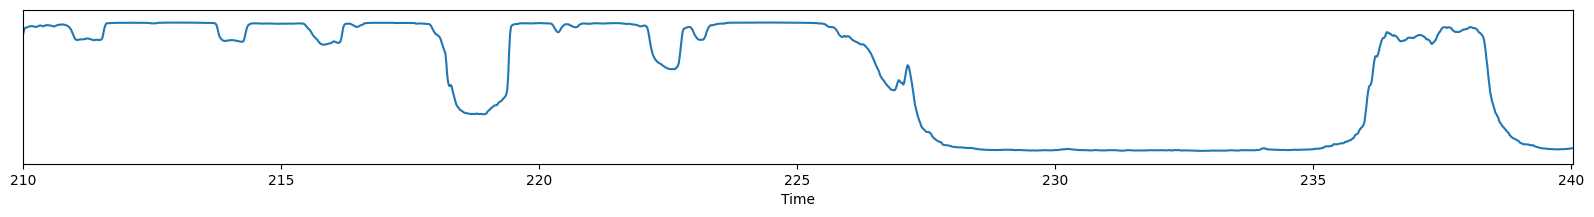

In [245]:
from pyannote.audio import Inference
vad = Inference(vad_model)

vad_probability = vad(test_file)
vad_probability

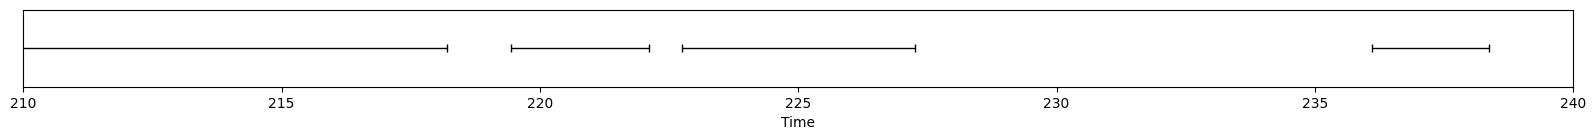

In [246]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

Let's see full audio with smoothed with window vad probabilities (blue line) and annotations (red segments)

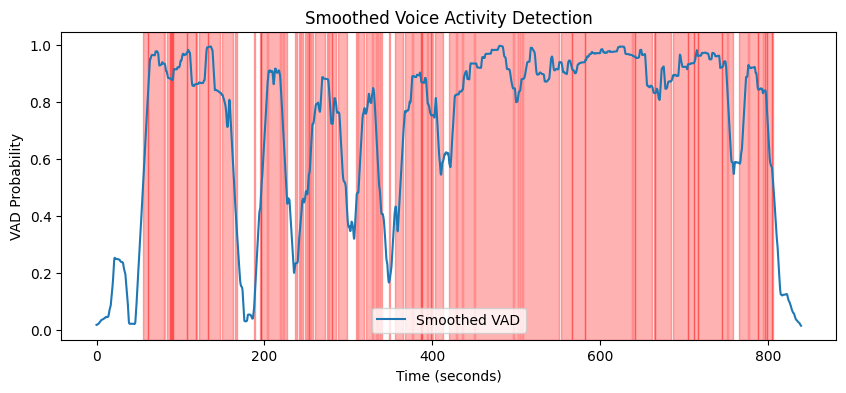

In [247]:
window_size = 1000
frame_rate = 57.5

# Apply a rolling window averaging
smoothed_vad = np.convolve(vad_probability.data[:,0], np.ones(window_size)/window_size, mode='same')

num_frames = len(vad_probability)
time_axis = np.linspace(0, num_frames / frame_rate, num_frames)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(time_axis, smoothed_vad, label='Smoothed VAD')

for segment in expected_output:
    start_time = segment.start
    end_time = segment.end
    plt.axvspan(start_time, end_time, color='red', alpha=0.3)
    
plt.xlabel('Time (seconds)')
plt.ylabel('VAD Probability')
plt.title('Smoothed Voice Activity Detection')
plt.legend()
plt.show()

## Fine-tuning a pretrained speaker segmentation model

Speaker diarization is the task of partitioning a given audio stream of recording into according to the speaker identity.

[`pyannote/segmentation`](https://hf.co/pyannote/segmentation) is a model that was pretrained to perform speaker diarization, but only locally, on 5s-long audio chunks. 

To load the speaker segmentation model, 

* accept the user conditions on [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation).
* login using `notebook_login` below

In [195]:
import torch
torch.__version__ = '2.1.0'
from pyannote.audio import Model

HF_TOKEN = '<YOUR_HF_TOKEN>'

model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_AUTH_TOKEN)

Model was trained with pytorch-lightning 2.0.2, yours is 1.9.4. Bad things will probably happen unless you upgrade pytorch-lightning to 2.x.


In [196]:
model

PyanNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (lstm): LSTM(60, 128, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=7, bias=

Let's visualize how it performs on our test file:

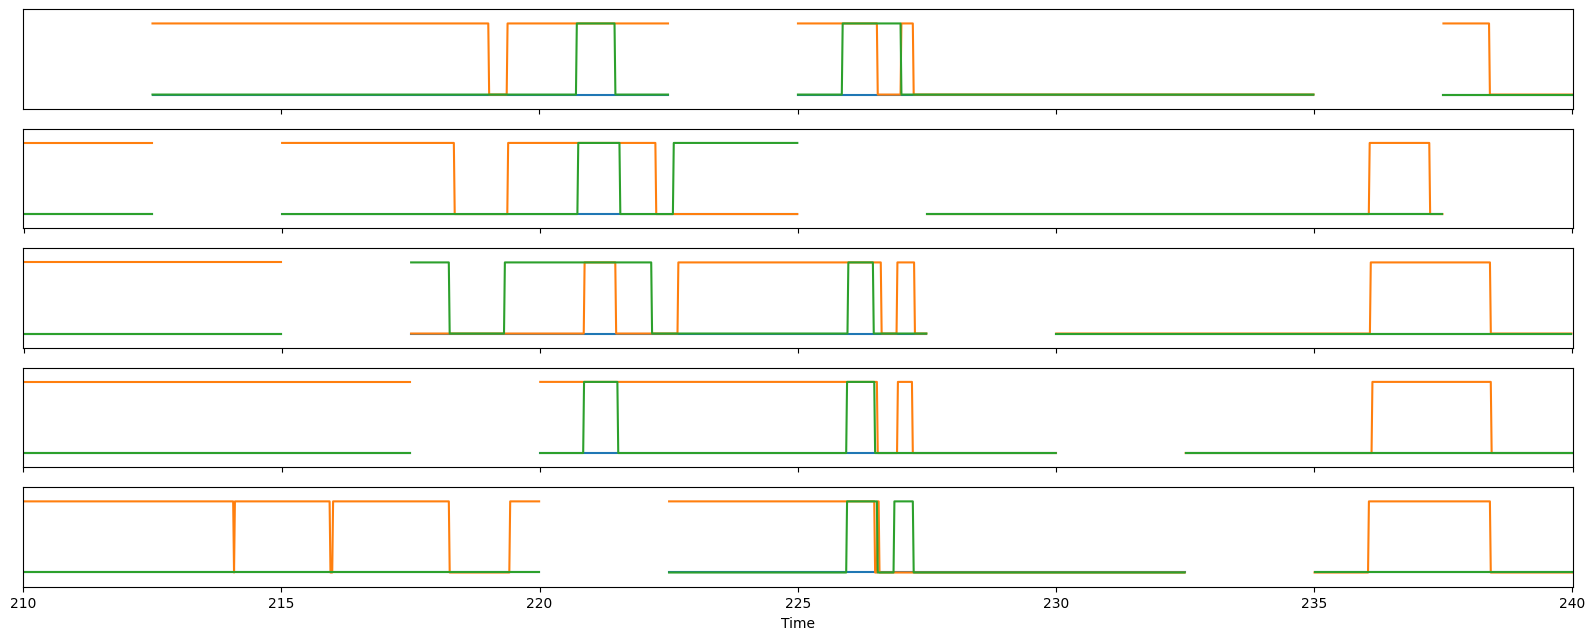

In [244]:
spk_probability = Inference(pretrained, step=2.5)(test_file)
spk_probability

A perfect output would look like that:

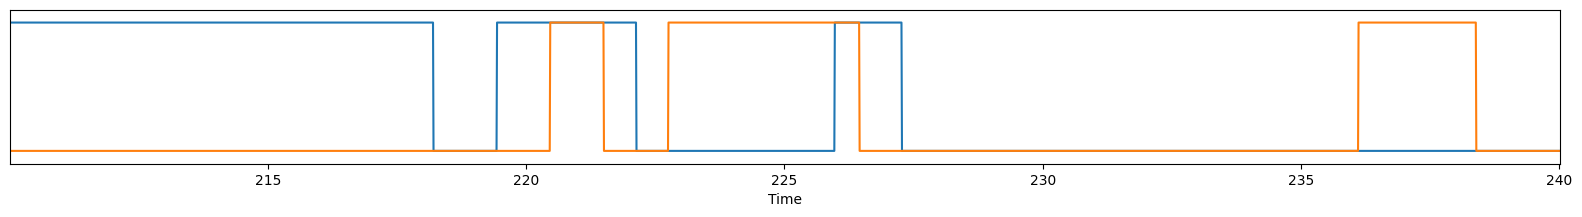

In [243]:
test_file["annotation"].discretize(notebook.crop, resolution=0.010)

We are going to fine-tune this pretrained model on the AMI dataset:

In [253]:
from pyannote.audio.tasks import SpeakerDiarization
seg_task = SpeakerDiarization(ami, duration=5.0, max_num_speakers=4, batch_size=64)

To check that fine-tuning was actually helpful, we need to evaluate the performance of the pretrained model, and compute the average local diarization error rate on a 5s window sliding over the whole test set. To do so, we need to create a helper function:

In [249]:
def test(model, protocol, subset="test"):
    from pyannote.audio.utils.signal import binarize
    from pyannote.audio.utils.metric import DiscreteDiarizationErrorRate
    from pyannote.audio.pipelines.utils import get_devices

    (device,) = get_devices(needs=1)
    metric = DiscreteDiarizationErrorRate()
    files = list(getattr(protocol, subset)())

    inference = Inference(model, device=device)

    for file in files:
        reference = file["annotation"]
        hypothesis = binarize(inference(file))
        uem = file["annotated"]
        _ = metric(reference, hypothesis, uem=uem)
        
    return abs(metric)

We can then evaluate the model and see its local DER:

In [250]:
der_pretrained = test(model=pretrained, protocol=ami, subset="test")
print(f"Local DER (pretrained) = {der_pretrained * 100:.1f}%")

Local DER (pretrained) = 17.9%


Next, we prepare the model for fine-tuning, simply by overriding its `task` attribute...

In [254]:
from copy import deepcopy
finetuned = deepcopy(pretrained)
finetuned.task = seg_task

... and we train it (for just one epoch)

In [255]:
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=5)
trainer.fit(finetuned)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 80000] | [1, 60, 293]                               
1 | lstm              | LSTM             | 1.4 M  | [1, 293, 60]  | [[1, 293, 256], [[8, 1, 1

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [257]:
der_finetuned = test(model=finetuned, protocol=ami, subset="test")
print(f"Local DER (finetuned) = {der_finetuned * 100:.1f}%")

Local DER (finetuned) = 17.8%


In [167]:
from creds import HF_AUTH_TOKEN
from pyannote.audio import Model, Pipeline

pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.0", use_auth_token=HF_AUTH_TOKEN)

Model was trained with pytorch-lightning 2.0.2, yours is 1.9.4. Bad things will probably happen unless you upgrade pytorch-lightning to 2.x.


Let's visualize how it performs on our test file:

In [170]:
orig_wav_path = 'example_wavs/vikanikita.wav'

diarization = pretrained_pipeline(orig_wav_path)
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=0.0s stop=0.2s speaker_SPEAKER_00
start=0.6s stop=4.5s speaker_SPEAKER_00
start=1.1s stop=7.7s speaker_SPEAKER_01


In [193]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def visualize_diarization(diarization):
    # Define a colormap to assign different colors to different speakers
    cmap = get_cmap('tab10')  # 'tab10' is a colormap with 10 distinct colors

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Iterate through the diarization results and plot each segment
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        turn_start = turn.start
        turn_end = turn.end
        speaker_color = cmap(int(speaker[-1]))  # Extract a color based on speaker ID

        # Plot each turn as a line segment
        plt.plot([turn_start, turn_end], [speaker, speaker], color=speaker_color, linewidth=10, label=speaker)

    # Set labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('Speaker')
    plt.title('Speaker Diarization')

    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Show the plot
    plt.show()

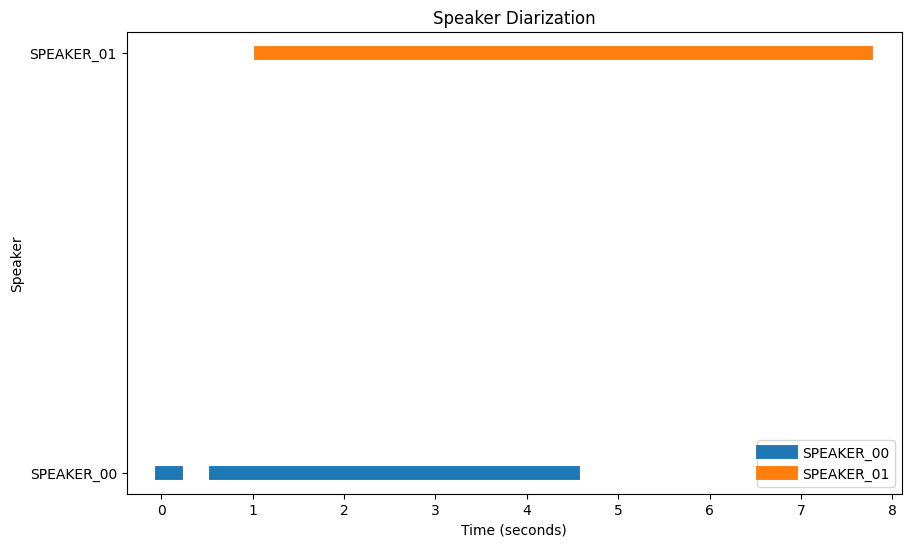

In [194]:
visualize_diarization(diarization)

In [262]:
import IPython
IPython.display.Audio(orig_wav_path)

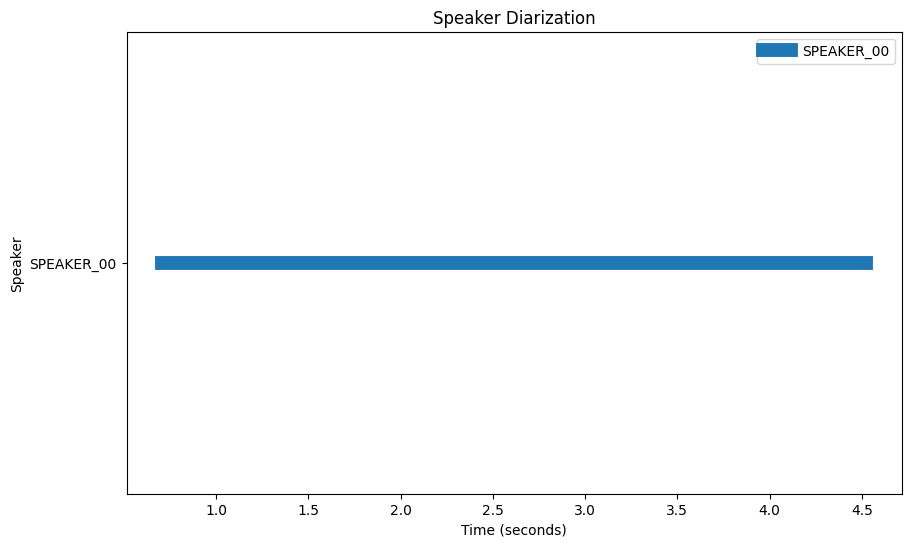

In [263]:
only_nikita_path = 'example_wavs/vikanikita-out0.wav'
diarization_nikita = pretrained_pipeline(only_nikita_path)
visualize_diarization(diarization_nikita)

In [264]:
IPython.display.Audio(only_nikita_path)

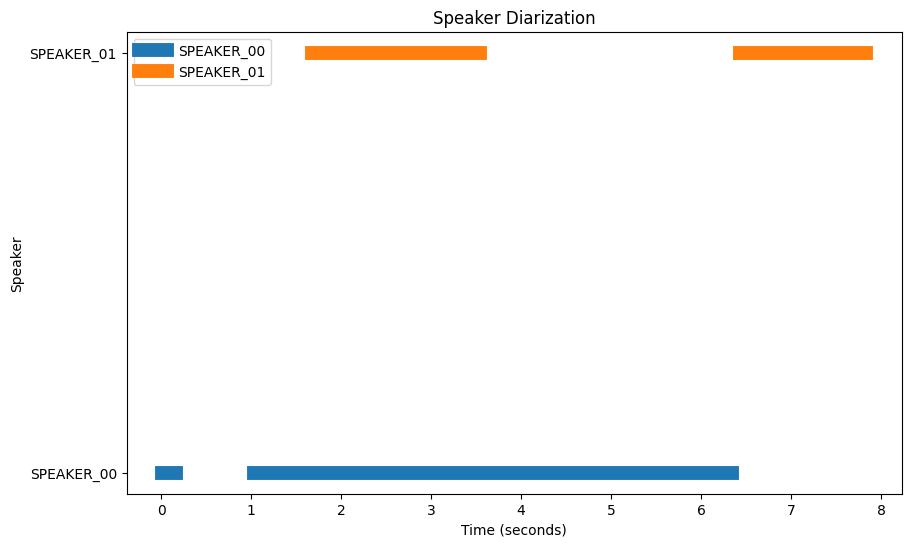

In [265]:
only_vika_path = 'example_wavs/vikanikita-out1.wav'
diarization_nikita = pretrained_pipeline(only_vika_path)
visualize_diarization(diarization_nikita)

In [266]:
IPython.display.Audio(only_vika_path)